In [1055]:
import numpy as np
np.set_printoptions(precision=4)
import numpy.random as npr
import numpy_financial as npf
import pandas as pd
import pandas_datareader as pdr

from scipy.optimize import curve_fit
import scipy.stats as scs

%matplotlib inline
from pylab import mpl, plt
import seaborn as sns
mpl.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (10, 6)

import\
    datetime as dt,\
    json,\
    math,\
    requests,\
    threading,\
    time
import warnings
warnings.filterwarnings('ignore')

import panel as pn
pn.extension('plotly')
import plotly.express as px
import hvplot.pandas



import yfinance as yf

from dotenv import find_dotenv, get_key

import quandl
quandl.ApiConfig.api_key = get_key(find_dotenv(), 'QUANDL_API_KEY')

API_KEY = get_key(find_dotenv(), 'ALPACA_API_KEY')
API_SECRET = get_key(find_dotenv(), 'ALPACA_SECRET_KEY')
APCA_API_BASE_URL = 'https://paper-api.alpaca.markets'
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
api = REST(
    API_KEY,
    API_SECRET,
    api_version='v2',
)

---

# APIs

Alpaca API<br>
Quandl API<br>
Yahoo Finance API [GitHub](https://github.com/ranaroussi/yfinance) [PyPI](https://pypi.org/project/yfinance/)<br>

---

In [85]:
sym = yf.Ticker('QQQ')

---

# Helper Functions

In [1040]:
def print_statistics (a1, a2):
    ''' Prints selected statistics (on top of scipy.stats).
    
    Parameters
    ==========
    a1, a2: ndarray objects
        results objects from simulation
    '''
    sta1 = scs.describe(a1)
    sta2 = scs.describe(a2)
    print('%14s %14s %14s' % ('statistic', 'data set 1', 'data set 2'))
    print(45 * '-')
    print('%14s %14.3f %14.3f' % ('size', sta1[0], sta2[0]))
    print('%14s %14.3f %14.3f' % ('min', sta1[1][0], sta2[1][0]))
    print('%14s %14.3f %14.3f' % ('max', sta1[1][1], sta2[1][1]))
    print('%14s %14.3f %14.3f' % ('mean', sta1[2], sta2[2]))
    print('%14s %14.3f %14.3f' % ('std', np.sqrt(sta1[3]), np.sqrt(sta2[3])))
    print('%14s %14.3f %14.3f' % ('skew', sta1[4], sta2[4]))
    print('%14s %14.3f %14.3f' % ('kurtosis', sta1[5], sta2[5]))
    
def gen_sn (M, I, anti_paths=True, mo_match=True):
    ''' Function to generate random numbers for simulation.
    
    Parameters
    ==========
    M: int
        number of time intervals for discretization
    I: int
        number of paths to be simulated
    anti_paths: boolean
        use of antithetic variates
    mo_match: boolean
        use of moment matching
    '''
    if anti_paths is True:
        sn = npr.standard_normal((M + 1, int(I / 2)))
        sn = np.concatenate((sn, -sn), axis=1)
    else:
        sn = npr.standard_normal((M + 1, I))
    if mo_match is True:
        sn = (sn - sn.mean()) / sn.std()
    return sn

---

# 12. Stochastics (Hilpisch's _Python for Finance_)

Pseudo Random Numbers<br>
Quasi Random Numbers based on Sobol sequences<br>
Simulation of Random Variables<br>
Simulation of Stochastic Processes<br>

Valuation of derivatives with European exercise<br>
Valuation of derivatives with American exercise<br>
Valuation of derivatives with Bermudan exercise<br>

Risk Analysis<br>
VaR Value at Risk
[Investopedia Part 1](https://www.investopedia.com/articles/04/092904.asp)
[Investopedia Part 2](https://www.investopedia.com/articles/04/101304.asp)<br>
Credit VaR<br>
Credit valuation adjustment<br>

(standard) normal distributions in finance are criticised, but many financial models rest directly on a (log-)normal distribution assumption; other models that don't can be Euler-discretized and approximated for the purposes of simulation by means of the normal distribution<br>
The Euler discretization scheme is exact for the geometric Brownian motion, but it is biased for the majority of other stochastic processes. Even if there is an exact scheme available, the use of an Euler scheme might be desirable for numerical and/or computational reasons.<br>

MCS Monte Carlo Simulation<br>
a numerical method for the evaluation of mathematical expressions like integrals and the valuation of financial derivatives<br>
high computational cost: millions of computations per value estimate<br>

---

# Black-Scholes-Merton Model for Options Pricing

## Static Representation

$$S_T = S_0 \, \text{exp}\left[\left(r - \frac{1}{2}\sigma^2\right)T + \sigma\sqrt{T}z\right]$$

$S_T$ stock index level at a future date $T$ <br>
$S_0$ the level of a stock index today <br>
$r$ constant riskless short rate <br>
$\sigma$ constant volatility (standard deviation of returns) of $S$; a major simplifying assumption is that volatility is constant <br>
$z$ standard normal random variable <br>

## Dynamic Representation

Black-Scholes-Merton SDE (geometric Brownian motion)<br>
$$d S_t = r S_t dt + \sigma S_t d Z_t$$
$S_t$ the value of the underlying at time $t$; the values of $S_t$ are log-normally distributed<br>
$\frac{dS_t}{S_t}$ the marginal returns are normally distributed<br>
$r$ the constant, riskless short rate<br>
$\sigma$ the constant instantaneous volatility<br>
$Z_t$ a standard Brownian motion<br>

---

Black-Scholes-Merton difference equation (exactly-discretized Euler scheme)<br>
$$S_t = S_{t - \Delta t} \text{exp} \left( \left( r - \frac{\sigma^2}{2} \right) \Delta t + \sigma\sqrt{\Delta t} z \right)$$
$\Delta t$ the fixed discretization interval<br>
$z_t$ a standard normally distributed random variable<br>
for $M$ time intervals, the length of the time interval is given as $\Delta t \equiv \frac{T}{M}$ where $T$ is the time horizon for the simulation<br>

the resulting end values for the index level are log-normally distributed<br>

     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min         20.215         24.339
           max        392.058        392.235
          mean        109.949        111.138
           std         40.095         40.174
          skew          1.119          1.090
      kurtosis          2.197          2.025
     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min         31.039         24.339
           max        369.806        392.235
          mean        110.628        111.138
           std         39.971         40.174
          skew          1.083          1.090
      kurtosis          1.960          2.025


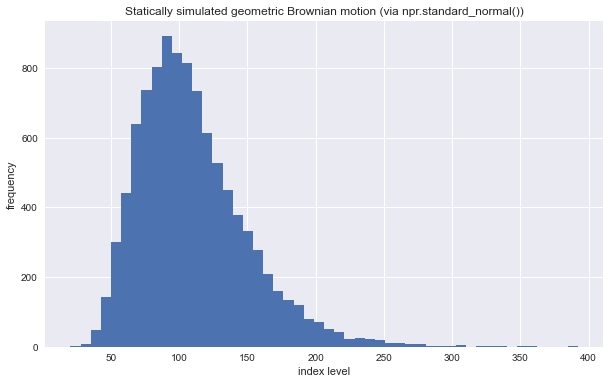

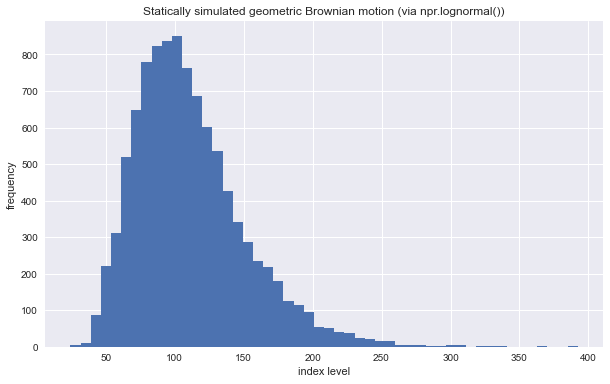

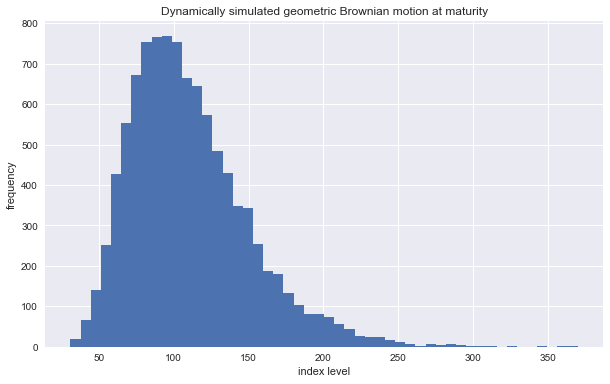

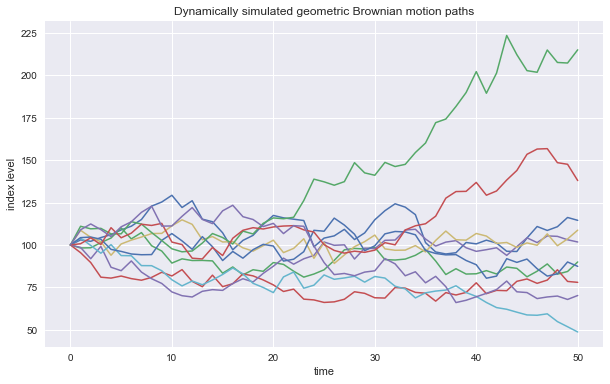

In [1007]:
# BSM Static Simulation

S0    = 100                  # the initial index level
r     = 0.05                 # the constant riskless short rate
sigma = 0.25                 # the constant volatility factor
T     = 2.0                  # the horizon in year fractions
I     = 10_000               # the number of simulations

M     = 50                   # the number of time intervals for the discretization
dt    = T / M                # the length of the time interval in year fractions
S     = np.zeros((M + 1, I)) # the 2D ndarray for the index levels
S[0]  = S0                   # the initial index level

# discretized simulation via vectorized expression
# normally distributed
ST1   = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * npr.standard_normal(I))
# log normally distributed
ST2   = S0 * npr.lognormal((r - 0.5 * sigma ** 2) * T, sigma * np.sqrt(T), size=I)

print_statistics(ST1, ST2)
# the statistics of both simulation results are quite similar
# the differences are primarily due to the simulation sampling error
# the discretization error, which is due to discretely simulating continuous stochastic processes,
#   is not a factor here because the simulation is generated statically

plt.figure(figsize=(10, 6));
plt.hist(ST1, bins=50);
plt.xlabel('index level');
plt.ylabel('frequency');
plt.title('Statically simulated geometric Brownian motion (via npr.standard_normal())');

plt.figure(figsize=(10, 6));
plt.hist(ST2, bins=50);
plt.xlabel('index level');
plt.ylabel('frequency');
plt.title('Statically simulated geometric Brownian motion (via npr.lognormal())');

# BSM Dynamic Simulation
#   the dynamic simulation allows us to
#     visualize paths
#     value options with American or Bermudan exercise, or options whose payoff is path-dependent

# discretized simulation via semi vectorized expression
#   the loop is over the points in time starting at t = 1 and ending at t = T
for t in range(1, M + 1):
    S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * npr.standard_normal(I))
    
print_statistics(S[-1], ST2)
    
plt.figure(figsize=(10, 6));
plt.hist(S[-1], bins=50);
plt.xlabel('index level');
plt.ylabel('frequency');
plt.title('Dynamically simulated geometric Brownian motion at maturity');

plt.figure(figsize=(10, 6));
plt.plot(S[:, :10], lw=1.5);
plt.xlabel('time');
plt.ylabel('index level');
plt.title('Dynamically simulated geometric Brownian motion paths');

---

### Square-Root Diffusion
Cox, Ingersoll, & Ross (1985)<br>

__Mean-Reverting Process__<br>
an important class of financial processes which are used to model short rates or volatility processes, for example<br>

__Square-Root Diffusion SDE__<br>
$$
dx_t = \kappa (\theta - x_t) dt + \sigma \sqrt{x_t} dZ_t
$$
$x_t$ the process level at date t; the values of $x_t$ are chi-squared distributed and remain strictly positive<br>
$\kappa$ the mean-reversion factor<br>
$\theta$ the long-term mean of the process<br>
$\sigma$ the constant volatility factor<br>
$Z_t$ a standard Brownian motion<br>

__Fully-Truncated Euler Discretization for Square-Root Diffusion__<br>
$$
\begin{align}
\tilde{x}_t &= \tilde{x}_s + \kappa (\theta - \tilde{x}^+_s) \Delta t + \sigma \sqrt{\tilde{x}^+_s} \sqrt{\Delta t} z_t \\
x_t &= \tilde{x}^+_t \\
\end{align}
$$
$s = t - \Delta t$<br>
$x^+ \equiv \text{max}(x, 0)$<br>
correlation is easily and consistently account for since one only draws standard normally distributed random numbers<br>

__Exact Non Central Chi-Square Distribution Discretization for Square-Root Diffusion__<br>
$$
x_t = \frac{\sigma^2 (1 - e^{- \kappa \Delta t})}{4 \kappa} \chi^{'2}_d \text{nc}
$$
noncentral chi-square distribution $\chi^{'2}_d$<br>
degrees of freedom $\text{df} = \frac{4 \theta \kappa}{\sigma^2}$<br>
noncentrality parameter $\text{nc} = \frac{4 \kappa e^{- \kappa \Delta t}}{\sigma^2 (1 - e^{- \kappa \Delta t})} x_s$<br>

CPU times: user 540 ms, sys: 81.5 ms, total: 621 ms
Wall time: 625 ms
CPU times: user 1.11 s, sys: 13.7 ms, total: 1.13 s
Wall time: 1.13 s
     statistic     data set 1     data set 2
---------------------------------------------
          size     250000.000     250000.000
           min          0.003          0.004
           max          0.059          0.060
          mean          0.020          0.020
           std          0.006          0.006
          skew          0.556          0.585
      kurtosis          0.454          0.523


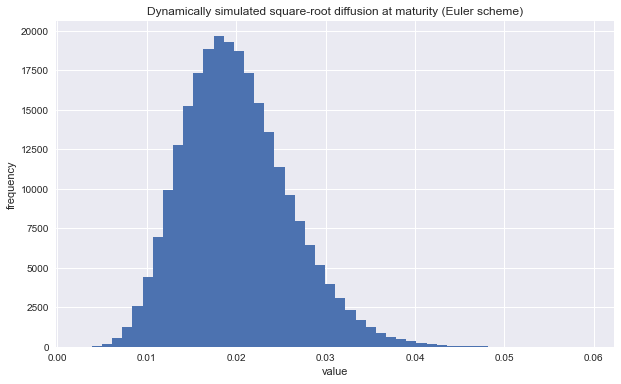

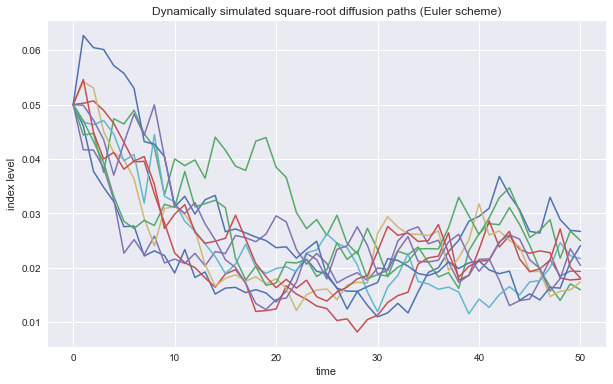

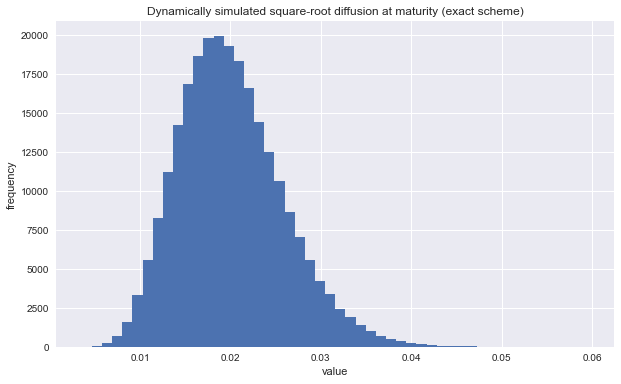

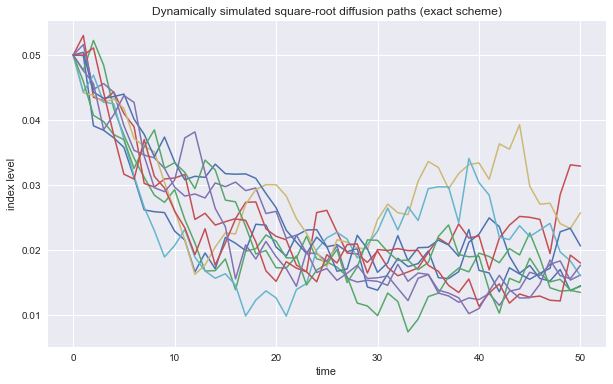

In [1006]:
# Square-Root Diffusion simulation

x0    = 0.05   # the initial value (e.g., for a short rate)
kappa = 3.0    # the mean-reversion factor
theta = 0.02   # the long-term mean
sigma = 0.1    # the constant volatility factor
I     = 250_000 # the number of path simulations
T     = 2.0    # the horizon in year fractions
M     = 50     # the number of time intervals for the discretization
dt    = T / M  # the length of the time interval in year fractions

# Euler discretization scheme via npr.standard_normal()
#   negative average drift due to x0 > 0
#   convergence to theta = 0.02
def srd_euler ():
    xh    = np.zeros((M + 1, I))
    x     = np.zeros_like(xh)
    xh[0] = x0
    x[0]  = x0
    for t in range(1, M + 1):
        xh[t] = (xh[t - 1] +
                 kappa * (theta - np.maximum(xh[t - 1], 0)) * dt +
                 sigma * np.sqrt(np.maximum(xh[t - 1], 0)) *
                 np.sqrt(dt) * npr.standard_normal(I))
    x = np.maximum(xh, 0)
    return x

# exact discretization scheme via npr.noncentral_chisquare()
def srd_exact ():
    x        = np.zeros((M + 1, I))
    x[0]     = x0
    for t in range(1, M + 1):
        df   = 4 * theta * kappa / sigma ** 2
        c    = (sigma ** 2 * (1 - np.exp(-kappa * dt))) / (4 * kappa)
        nc   = np.exp(-kappa * dt) / c * x[t - 1]
        x[t] = c * npr.noncentral_chisquare(df, nc, size=I)
    return x

%time x1 = srd_euler()
%time x2 = srd_exact()

print_statistics(x1[-1], x2[-1])
# performance: statistical properties
#   the biased Euler scheme performs quite well when it comes to the desired statistical properties
# performance: computational efficiency
#   sampling from the noncentral chi-square distribution is more computationally demanding
#   than from the standard normal distribution

plt.figure(figsize=(10, 6));
plt.hist(x1[-1], bins=50);
plt.xlabel('value');
plt.ylabel('frequency');
plt.title('Dynamically simulated square-root diffusion at maturity (Euler scheme)');

plt.figure(figsize=(10, 6));
plt.plot(x1[:, :10], lw=1.5);
plt.xlabel('time');
plt.ylabel('index level');
plt.title('Dynamically simulated square-root diffusion paths (Euler scheme)');

plt.figure(figsize=(10, 6));
plt.hist(x2[-1], bins=50);
plt.xlabel('value');
plt.ylabel('frequency');
plt.title('Dynamically simulated square-root diffusion at maturity (exact scheme)');

plt.figure(figsize=(10, 6));
plt.plot(x2[:, :10], lw=1.5);
plt.xlabel('time');
plt.ylabel('index level');
plt.title('Dynamically simulated square-root diffusion paths (exact scheme)');

---

### Stochastic Volatility Models
early 1990s<br>

__Heston (1993) Stochastic Volatility SDE__<br>
$$
\begin{align}
dS_t &= r S_t dt + \sqrt{v_t} S_t dZ^1_t \\
dv_t &= \kappa_v (\theta_v - v_t) dt + \sigma_v \sqrt{v_t} dZ^2_t \\
dZ^1_t dZ^2_t &= \rho \\
\end{align}
$$
$\rho$ the instantaneous correlation between the two standard Brownian motions $dZ^1_t$, $dZ^2_t$ accounts for a stylized fact called the _leverage effect_ which states that volatility goes up in times of stress (declining markets) and goes down in times of a bull market (rising markets)<br>
to account for the correlation between the two stochastic processes, one needs to determine the Cholesky decomposition of the correlation matrix<br>

     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min         20.048          0.171
           max        562.190          0.335
          mean        108.279          0.243
           std         51.834          0.020
          skew          1.702          0.138
      kurtosis          5.404          0.128


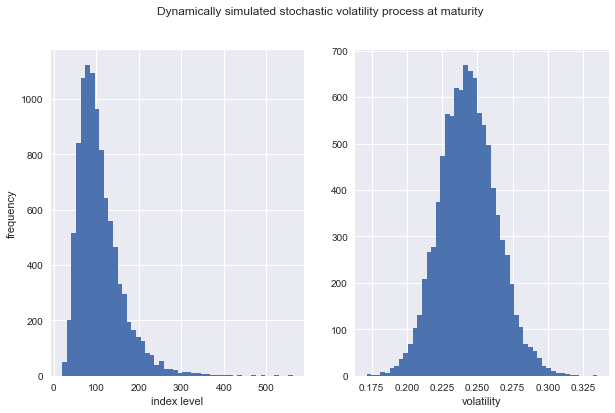

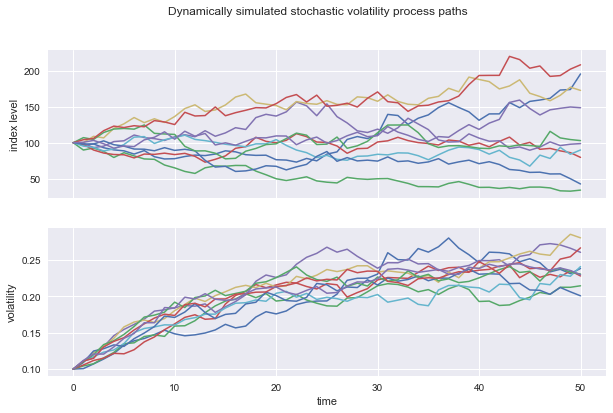

In [1016]:
S0    = 100
r     = 0.05
v0    = 0.1  # initial instantaneous volatility value
kappa = 3.0
theta = 0.25
sigma = 0.1
rho   = 0.6  # fixed correlation between two Brownian motions
T     = 1.0
M     = 50
I     = 10_000
dt    = T / M

corr_mat = np.zeros((2, 2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat) # Cholesky decomposition

# generate 3D random numbers
#   use set 0 for the index process
#   use set 1 for the volatility process
ran_num = npr.standard_normal((2, M + 1, I))

# volatility process simulation
#   biased Euler scheme for square-root diffusion
v       = np.zeros_like(ran_num[0])
vh      = np.zeros_like(v)
v[0]    = v0
vh[0]   = v0
for t in range(1, M + 1):
    # select the relevant random number subset and transform it via the Cholesky matrix
    ran = np.dot(cho_mat, ran_num[:, t, :])
    vh[t] = (vh[t - 1] +
             kappa * (theta - np.maximum(vh[t - 1], 0)) * dt +
             sigma * np.sqrt(np.maximum(vh[t - 1], 0)) *
             np.sqrt(dt) * ran[1])
v = np.maximum(vh, 0)

# index level process simulation
#   exact Euler scheme for geometric Brownian motion
S = np.zeros_like(ran_num[0])
S[0] = S0
for t in range(1, M + 1):
    # select the relevant random number subset and transform it via the Cholesky matrix
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[0] * np.sqrt(dt))
    
print_statistics(S[-1], v[-1])
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.hist(S[-1], bins=50)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax2.hist(v[-1], bins=50)
ax2.set_xlabel('volatility');
fig.suptitle('Dynamically simulated stochastic volatility process at maturity');

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
ax1.plot(S[:, :10], lw=1.5);
ax1.set_ylabel('index level');
ax2.plot(v[:, :10], lw=1.5);
ax2.set_xlabel('time');
ax2.set_ylabel('volatility');
fig.suptitle('Dynamically simulated stochastic volatility process paths');

# the volatility process is drifting positively on average and converges to theta = 0.25

---

### Jump Diffusion
Merton's 1976 Jump Diffusion Model enhances the BSM setup through a model component generating jumps with log-normal distribution<br>
an important stylized/empirial fact is the existence of jumps in asset prices and volatility, for example<br>

__Merton Risk-Neutral Jump Diffusion SDE__<br>
$$
dS_t = (r - r_j) S_t dt + \sigma S_t dZ_t + J_t S_t dN_t
$$
$S_t$ index level at date $t$<br>
$r$ constant riskless short rate<br>
$r_j \equiv \lambda \cdot (e^{\mu_j + \delta^2 / 2} - 1)$ the drift correction for jump to maintain risk neutrality<br>
$\sigma$ the constant volatility of $S$<br>
$Z_t$ a standard Brownian motion<br>
$J_t$ the jump at date $t$ with distribution $\text{log}(1 + J_t) \approx \textbf{N} \left( \text{log}(1 + \mu_j) - \frac{\delta^2}{2}, \delta^2 \right)$ with $\textbf{N}$ as the cumulative distribution function of a standard normal random variable<br>
$N_t$ a Poisson process with intensity $\lambda$<br>

__Euler Discretization for Merton Risk-Neutral Jump Diffusion__<br>
$$
S_t = S_{t - \Delta t} \left( e^{(r - r_j - \sigma^2 / 2) \Delta t + \sigma \sqrt{\Delta t} z^1_t} + (e^{\mu_j + \delta z^2_t} - 1) y_t \right)
$$
$z^n_t$ are standard normally distributed<br>
$y_t$ are Poisson distributed with intensity $\lambda$<br>

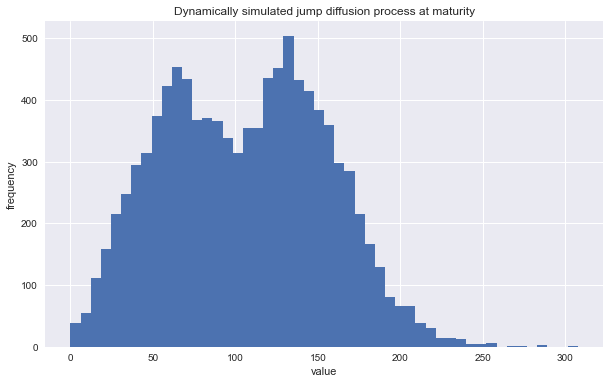

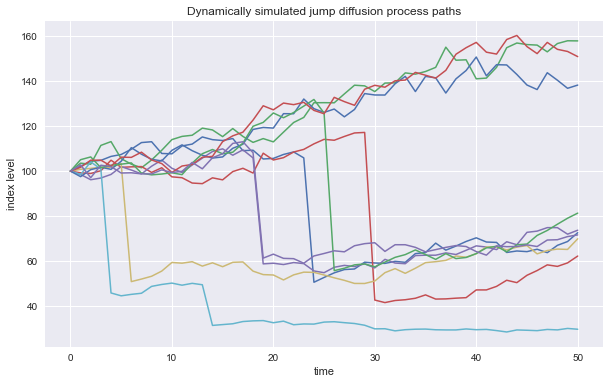

In [1036]:
S0    = 100
r     = 0.05
sigma = 0.2
lamb  = 0.75                                       # the jump intensity
mu    = -0.6                                       # the mean jump size
delta = 0.25                                       # the jump volatility
rj    = lamb * (np.exp(mu + 0.5 * delta ** 2) - 1) # the drift correction
T     = 1.0
M     = 50
I     = 10_000
dt    = T / M

S = np.zeros((M + 1, I))
S[0] = S0
sn1 = npr.standard_normal((M + 1, I))    # standard normally distributed random numbers
sn2 = npr.standard_normal((M + 1, I))    # standard normally distributed random numbers
poi = npr.poisson(lamb * dt, (M + 1, I)) # Poisson distributed random numbers
for t in range(1, M + 1, 1):
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt +
                       sigma * np.sqrt(dt) * sn1[t]) +
                       (np.exp(mu + delta * sn2[t]) - 1) *
                       poi[t])
    S[t] = np.maximum(S[t], 0)
    
plt.figure(figsize=(10, 6));
plt.hist(S[-1], bins=50);
plt.xlabel('value');
plt.ylabel('frequency');
plt.title('Dynamically simulated jump diffusion process at maturity');

plt.figure(figsize=(10, 6));
plt.plot(S[:, :10], lw=1.5);
plt.xlabel('time');
plt.ylabel('index level');
plt.title('Dynamically simulated jump diffusion process paths');

---

### Variance Reduction
improve the matching of the first two moments of the (standard) normal distribution<br>

In [1037]:
print('%15s %15s' % ('Mean', 'Std. Deviation'))
print(31 * '-')
for i in range(1, 31, 2):
    npr.seed(100)
    sn = npr.standard_normal(i ** 2 * 10_000)
    print('%15.12f %15.12f' % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
 0.001150944833  1.006296354600
 0.002841204001  0.995987967146
 0.001998082016  0.997701714233
 0.001322322067  0.997771186968
 0.000592711311  0.998388962646
-0.000339730751  0.998399891450
-0.000228109010  0.998657429396
 0.000295768719  0.998877333340
 0.000257107789  0.999284894532
-0.000357870642  0.999456401088
-0.000528443742  0.999617831131
-0.000300171536  0.999445228838
-0.000162924037  0.999516059328
 0.000135778889  0.999611052522
 0.000182006048  0.999619405229


__Antithetic Variates__<br>
corrects the first moment, but not the second moment<br>
this approach draws only half the desired number of random draws and adds the same set of random numbers with the opposite sign afterward (i.e., if the random number generator draws 0.5, then another number with value -0.5 is added to the set). by construction, the mean value of such a data set must equal zero<br>

In [1038]:
sn = npr.standard_normal(int(10_000 / 2))
sn = np.concatenate((sn, -sn))
display(np.shape(sn), sn.mean())

print('%15s %15s' % ('Mean', 'Std. Deviation'))
print(31 * '-')
for i in range(1, 31, 2):
    npr.seed(1000)
    sn = npr.standard_normal(i ** 2 * int(10_000 / 2))
    sn = np.concatenate((sn, -sn))
    print('%15.12f %15.12f' % (sn.mean(), sn.std()))

(10000,)

2.842170943040401e-18

           Mean  Std. Deviation
-------------------------------
 0.000000000000  1.009653753942
-0.000000000000  1.000413716783
 0.000000000000  1.002925061201
-0.000000000000  1.000755212673
 0.000000000000  1.001636910076
-0.000000000000  1.000726758438
-0.000000000000  1.001621265149
 0.000000000000  1.001203722778
-0.000000000000  1.000556669784
-0.000000000000  1.000113464185
-0.000000000000  0.999435175324
-0.000000000000  0.999356961431
-0.000000000000  0.999641436845
-0.000000000000  0.999642768905
-0.000000000000  0.999638303451


__Moment Matching__<br>
corrects both the first moment and the second moment<br>

In [1039]:
sn = npr.standard_normal(10_000)
display(sn.mean(), sn.std())
sn_new = (sn - sn.mean()) / sn.std()
display(sn_new.mean(), sn_new.std())

-0.001165998295162494

0.991255920204605

-2.3803181647963357e-17

0.9999999999999999

---

### Valuation of Contingent Claims (options, derivatives, hybrid instruments)
in a risk-neutral world, the value of a contingent claim is the discounted expected payoff under the risk-neutral (martingale) measure<br>
this is the probability measure that makes all risk factors (stocks, indices, etc.) drift at the riskless short rate, making the discounted processes martingales<br>
according to the Fundamental Theory of Asset Pricing, the existence of such a probability measure is equivalent to the absence of arbitrage<br>

__Option__<br>
The right to buy (call option) or sell (put option) a specified financial instrument at a given maturity date (European option), or over a specified time period (American option), at a given price (strike price)<br>

__Payoff of European Call Option on an index at maturity__<br>
$$
h(S_T) \equiv \text{max}(S_T - K, 0)
$$
$S_T$ the index level at maturity date $T$<br>
$K$ the strike price<br>

__Pricing by Risk-Neutral Expectation__<br>
given a--or in complete markets, the--risk-neutral measure for the relevant stochastic process, the price of an option is<br>
$$
C_0 = e^{-rT} \textbf{E}^Q_0 (h(S_T)) = e^{-rT} \int^{\infty}_0 h(s) q(s) ds
$$

__Risk-Neutral Monte Carlo Estimator for European Call Option__<br>
$$
\begin{align}
\tilde{C_0} &= e^{-rT} \frac{1}{I} \sum_{i = 1}^I h \left( \tilde{S}^i_T \right)
& \text{where}\, \tilde{S}^i_T \,\text{is the}\, T\text{th simulated index level at maturity} \\
\end{align}
$$

$$
C_0 = e^{-rT} \frac{1}{I} \sum_I \text{max} (S_T (i) - K, 0)
$$
$S_T(i)$ is the $i$th simulated value of the underlying at maturity $T$ for a total number of simulated path $I$ with $i = 1, 2, ..., I$<br>

In [1041]:
S0    = 100
r     = 0.05
sigma = 0.25
T     = 1.0
I     = 50_000

def gbm_mcs_stat (K):
    ''' Valuation of European call option in Black-Scholes-Merton by Monte Carlo simulation
    (of index level at maturity)
    
    Parameters
    ==========
    K: float
        (positive) strike price of the option
        
    Returns
    =======
    C0: float
        estimated present value of European call option
    '''
    sn = gen_sn(1, I)
    # simulate index level at maturity
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * sn[1])
    # calculate payoff at maturity
    hT = np.maximum(ST - K, 0)
    # calculate MCS estimator
    C0 = np.exp(-r * T) * np.mean(hT)
    return C0

gbm_mcs_stat(K=105)

10.044221852841922

In [1042]:
M = 50 # the number of time intervals for the discretization

def gbm_mcs_dyna (K, option='call'):
    ''' Valuation of European options in Black-Scholes-Merton
    by Monte Carlo simulation (of index level paths)
    
    Parameters
    ==========
    K: float
        (positive) strike price of the option
    option: string
        type of the option to be valued ('call', 'put')
        
    Returns
    =======
    C0: float
        estimated present value of European call option
    '''
    dt = T / M
    # simulation of index level paths
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * sn[t])
    # case-based calculation of payoff
    if option == 'call':
        hT = np.maximum(S[-1] - K, 0)
    else:
        hT = np.maximum(K - S[-1], 0)
    # calculation of MCS estimator
    C0 = np.exp(-r * T) * np.mean(hT)
    return C0

gbm_mcs_dyna(K=110, option='call')

7.950008525028434

In [1043]:
gbm_mcs_dyna(K=110, option='put')

12.629934942682004

---

how well do these simulation-based valuation approaches perform relative to the benchmark value from the BSM valuation formula?<br>
generate option values/estimates for a range of strike prices using the analytical option pricing formula for European calls<br>
compare the results from the static simulation and dynamic valuation approaches with precise analytical values<br>
all valuation differences are smaller than 1% absolutely, with both positive and negative differences<br>
as a general rule, the quality of the Monte Carlo estimator can be controlled for by adjusting the number of time intervals M used and/or the number of paths I simulated<br>

In [1044]:
# Valuation of European call options in Black-Scholes-Merton model
# including Vega function and implied volatility estimation

def bsm_call_value (S0, K, T, r, sigma):
    ''' Valuation of European call option in BSM model.
    Analytical formula.
    
    Parameters
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        maturity date (in year fractions)
    r: float
        constant risk-free short rate
    sigma: float
        volatility factor in diffusion term
        
    Returns
    =======
    value: float
        present value of the European call option
    '''
    from math import log, sqrt, exp
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    # stats.norm.cdf --> cumulative distribution function for normal distribution
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return value

def bdm_vega (S0, K, T, r, sigma):
    ''' Vega of European option in BSM model.
    
    Parameters
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        maturity date (in year fractions)
    r: float
        constant risk-free short rate
    sigma: float
        volatility factor in diffusion term
        
    Returns
    =======
    vega: float
        partial derivative of BSM formula with respect to sigma, i.e. Vega
    '''
    from math import log, sqrt
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    vega = S0 * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

# implied volatility function
def bsm_call_imp_vol (S0, K, T, r, C0, sigma_est, it=100):
    ''' Implied volatility of European call option in BSM model.
    
    Parameters
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        maturity date (in year fractions)
    r: float
        constant risk-free short rate
    sigma_est: float
        estimate of implied volatility
    it: integer
        number of iterations
        
    Returns
    =======
    sigma_est: float
        numerically estimated implied volatility
    '''
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0) / bsm_vega(S0, K, T, r, sigma_est))
    return sigma_est

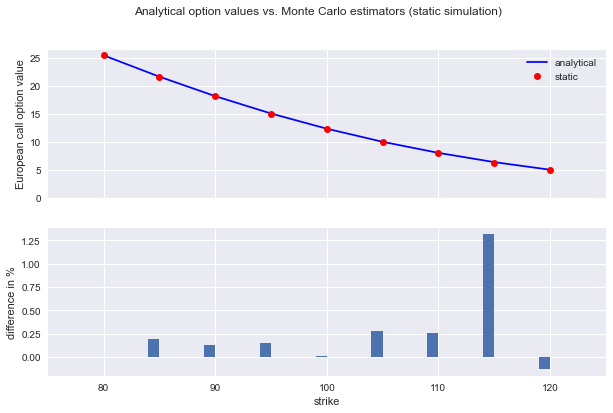

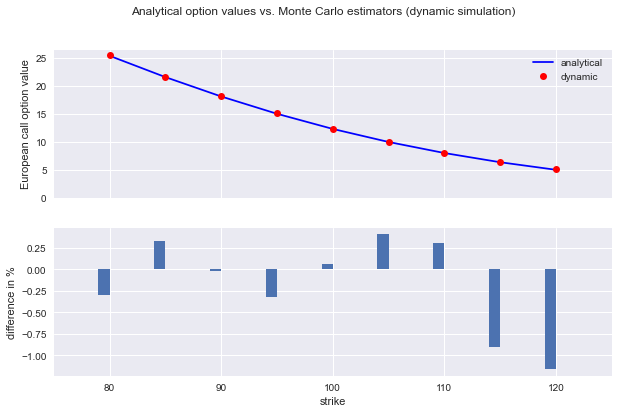

In [1049]:
stat_res = []
dyna_res = []
anal_res = []
k_list = np.arange(80, 120.1, 5)
npr.seed(100)

for K in k_list:
    stat_res.append(gbm_mcs_stat(K))
    dyna_res.append(gbm_mcs_dyna(K))
    anal_res.append(bsm_call_value(S0, K, T, r, sigma))
    
stat_res = np.array(stat_res)
dyna_res = np.array(dyna_res)
anal_res = np.array(anal_res)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6));
ax1.plot(k_list, anal_res, 'b', label='analytical');
ax1.plot(k_list, stat_res, 'ro', label='static');
ax1.set_ylabel('European call option value');
ax1.legend(loc=0);
ax1.set_ylim(bottom=0);
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - stat_res) / anal_res * 100, wi);
ax2.set_xlabel('strike');
ax2.set_ylabel('difference in %');
ax2.set_xlim(left=75, right=125);
fig.suptitle('Analytical option values vs. Monte Carlo estimators (static simulation)');

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6));
ax1.plot(k_list, anal_res, 'b', label='analytical');
ax1.plot(k_list, dyna_res, 'ro', label='dynamic');
ax1.set_ylabel('European call option value');
ax1.legend(loc=0);
ax1.set_ylim(bottom=0);
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - dyna_res) / anal_res * 100, wi);
ax2.set_xlabel('strike');
ax2.set_ylabel('difference in %');
ax2.set_xlim(left=75, right=125);
fig.suptitle('Analytical option values vs. Monte Carlo estimators (dynamic simulation)');

---

__Valuation of American Option via Optimal Stopping Problem__<br>
an optimal stopping problem has to be solved to come up with a fair value of the option<br>
$$
V_0 = \underset{r \in \{0, \Delta t, 2 \Delta t, ..., T\}}{\text{sup}} e^{-rT} \textbf{E}^Q_0 (h_{\tau}(S_{\tau}))
$$

__LSM Least-Squares Monte Carlo__<br>
Longstaff & Schwartz (2001)<br>
the value of an American/Bermudan option at any given date $t$ is given as
$$
V_t(s) = \text{max}(h_t (s), C_t (s))
$$
where $C_t (s) = \textbf{E}^Q_t (e^{-r \Delta t} V_{t + \Delta t} (S_{t + \Delta t} | S_t = s)$ is the continuation value of the option given an index level of $S_t = s$<br>

In [1050]:
def gbm_mcs_amer (K, option='call'):
    ''' Valuation of American option in Black-Scholes-Merton
    by Monte Carlo simulation by LSM algorithm
    
    Parameters
    ==========
    K: float
        (positive) strike price of the option
    option: string
        type of the option to be valued ('call', 'put')
        
    Returns
    =======
    C0: float
        estimated present value of American call option
    '''
    dt = T / M
    df = np.exp(-r * dt)
    # simulation of index levels
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * sn[t])
    # case based calculation of payoff
    if option == 'call':
        h = np.maximum(S - K, 0)
    else:
        h = np.maximum(K - S, 0)
    # LSM algorithm
    V = np.copy(h)
    for t in range(M - 1, 0, -1):
        reg = np.polyfit(S[t], V[t + 1] * df, 7)
        C = np.polyval(reg, S[t])
        V[t] = np.where(C > h[t], V[t + 1] * df, h[t])
    # MCS estimator
    C0 = df * np.mean(V[1])
    return C0

gbm_mcs_amer(110, option='call')

7.721705606305353

In [1051]:
gbm_mcs_amer(110, option='put')

13.609997625418051

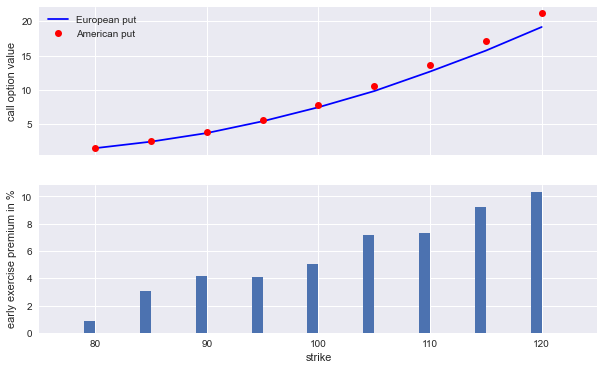

In [1052]:
euro_res = []
amer_res = []
k_list = np.arange(80, 120.1, 5)
for K in k_list:
    euro_res.append(gbm_mcs_dyna(K, 'put'))
    amer_res.append(gbm_mcs_amer(K, 'put'))
euro_res = np.array(euro_res)
amer_res = np.array(amer_res)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
ax1.plot(k_list, euro_res, 'b', label='European put')
ax1.plot(k_list, amer_res, 'ro', label='American put')
ax1.set_ylabel('call option value')
ax1.legend(loc=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (amer_res - euro_res) / euro_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('early exercise premium in %')
ax2.set_xlim(left=75, right=125);

---

__VaR Value at Risk__<br>
limited ability to capture tail risk<br>
a number denoted in currency units (e.g., USD, EUR, JPY) indicating a loss (of a portfolio, a single position, etc.) that is not exceeded with some confidence level (probability) over a given period of time<br>

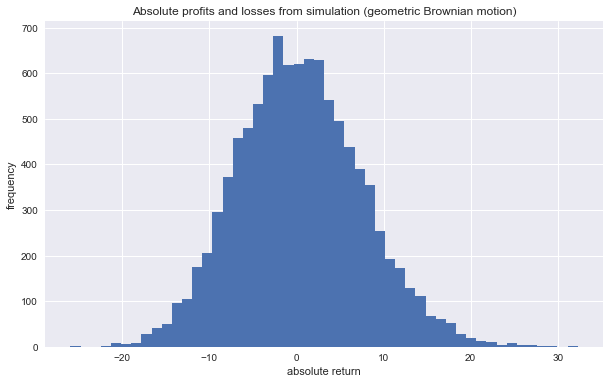

In [1054]:
S0 = 100
r  = 0.05
sigma = 0.25
T = 30 / 365
I = 10_000
# simulate end of period values for the geometric Brownian motion
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * npr.standard_normal(I))
# calculate the absolute profits and losses per simulation run and sort the values
R_gbm = np.sort(ST - S0)

plt.figure(figsize=(10, 6));
plt.hist(R_gbm, bins=50);
plt.xlabel('absolute return');
plt.ylabel('frequency');
plt.title('Absolute profits and losses from simulation (geometric Brownian motion)');

---

# Stochastic Processes

__Stochastic Process__<br>
a sequence of random variables<br>
similar to a sequence of repeated simulations of a random variable, but draws are typically not independent but rather depend on the result(s) of the previous draw(s)<br>

__Markov Property__<br>
"tomorrow's value of the simulated process only depends on today's state of the process, and not any other more "historic" state or even the whole path history"<br>
the process is called memoryless<br>

---

# Probability Distirbution Functions

__Beta Distribution__<br>
npr.beta(a, b[, size]) over [0, 1]<br>

__Binomial Distribution__<br>
npr.binomial(n, p[, size])<br>

__Chi Squared Distribution__<br>
npr.chisquare(df[, size])<br>

__Dirichlet Distribution__<br>
npr.dirichlet(alpha[, size])<br>

__Exponential Distribution__<br>
npr.exponential([scale, size])<br>

__F Distribution__<br>
npr.f(dfnum, dfden[, size])<br>

__Gamma Distribution__<br>
npr.gamma(shape[, scale, size])<br>

__Geometric Distribution__<br>
npr.geometric(p[, size])<br>

__Gumbel Distribution__<br>
npr.gumbel([loc, scale, size])<br>

__Hypergeometric Distribution__<br>
npr.hypergeometric(ngood, nbad, nsample[, size])<br>

__Laplace/Double-Exponential Distribution__<br>
npr.laplace([loc, scale, size])<br>

__Logistic Distribution__<br>
npr.logistic([loc, scale, size])<br>

__Log Normal Distribution__<br>
npr.lognormal([mean, sigma, size])<br>

__Logarithmic Series Distribution__<br>
npr.logseries(p[, size])<br>

__Multinomial Distribution__<br>
npr.multinomial(n, pvals[, size])<br>

__Multivariate Normal Distribution__<br>
npr.multivariate_normal(mean, cov[, size])<br>

__Negative Binomial Distribution__<br>
npr.negative_binoomial(n, p[, size])<br>

__Non Central Chi Squared Distribution__<br>
npr.noncentral_chisquare(df, nonc[, size])<br>

__Non Central F Distribution__<br>
npr.noncentral_f(dfnum, dfden, nonc[, size])<br>

__Normal/Gaussian Distribution__<br>
npr.normal([loc, scale, size])<br>

__Pareto II / Lomax Distribution__<br>
npr.pareto(a[, size])<br>

__Poisson Distribution__<br>
npr.poisson([lam, size])<br>

__Power Distribution__<br>
npr.power(a[, size]) in [0, 1] with positive exponent a - 1<br>

__Rayleigh Distribution__<br>
npr.rayleigh([scale, size])<br>

__Standard Cauchy Distribution__<br>
npr.standard_cauchy([size]) with mode = 0<br>

__Standard Exponential Distribution__<br>
npr.standard_exponential([size])<br>

__Standard Gamma Distribution__<br>
npr.standard_gamma(shape[, size])<br>

__Standard Normal Distribution__<br>
npr.standard_normal([size]) with mean = 0, stdev = 1<br>

__Student's t Distribution__<br>
npr.standard_t(df[, size]) with df degrees of freedom<br>

__Triangular Distribution__<br>
npr.triangular(left, mode, right[, size]) over the interval [left, right]<br>

__Uniform Distribution__<br>
npr.uniform([low, high, size])<br>

uniform random numbers in the interval [a, b) with shape<br>
npr.rand(shape) * (b - a) + a<br>

standard normal distribution<br>
npr.randn(shape)

discrete uniform distribution<br>
npr.randint(low_inclusive, high_exclusive, shape)<br>
npr.random_integers(low_inclusive, high_inclusive, shape)<br>

continuous uniform distribution [0, 1)<br>
npr.random_sample(shape)<br>
npr.random(shape)<br>
npr.ranf(shape)<br>
npr.sample(shape)<br>

uniform or nonuniform<br>
npr.choice(list, shape, probabilities)<br>

__Von Mises Distribution__<br>
npr.vonmises(mu, kappa[, size])<br>

__Wald / Inverse Gaussian Distribution__<br>
npr.wald(mean, scale[, size])<br>

__Weibull Distribution__<br>
npr.weibull(a[, size])<br>

__Zipf Distribution__<br>
npr.zipf(a[, size])<br>

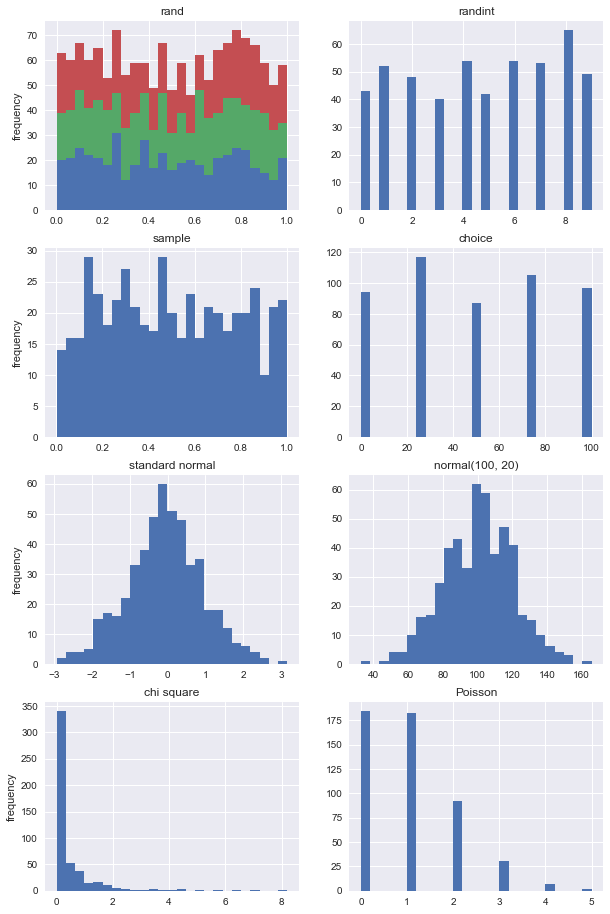

In [853]:
# visualizing NumPy distribution functions

sample_size = 500
rn1 = npr.rand(sample_size, 3)
rn2 = npr.randint(0, 10, sample_size)
rn3 = npr.sample(sample_size)
rn4 = npr.choice([0, 25, 50, 75, 100], sample_size)
rn5 = npr.standard_normal(sample_size)              # mean = 0, std = 1
rn6 = npr.normal(100, 20, sample_size)              # mean = 100, std = 20
rn7 = npr.chisquare(df=0.5, size=sample_size)       # 0.5 degrees of freedom
rn8 = npr.poisson(lam=1.0, size=sample_size)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(10, 16))
ax1.hist(rn1, bins=25, stacked=True);
ax1.set_title('rand');
ax1.set_ylabel('frequency');
ax2.hist(rn2, bins=25);
ax2.set_title('randint');
ax3.hist(rn3, bins=25);
ax3.set_title('sample');
ax3.set_ylabel('frequency');
ax4.hist(rn4, bins=25)
ax4.set_title('choice');
ax5.hist(rn5, bins=25);
ax5.set_title('standard normal');
ax5.set_ylabel('frequency');
ax6.hist(rn6, bins=25);
ax6.set_title('normal(100, 20)');
ax7.hist(rn7, bins=25);
ax7.set_title('chi square');
ax7.set_ylabel('frequency');
ax8.hist(rn8, bins=25);
ax8.set_title('Poisson');

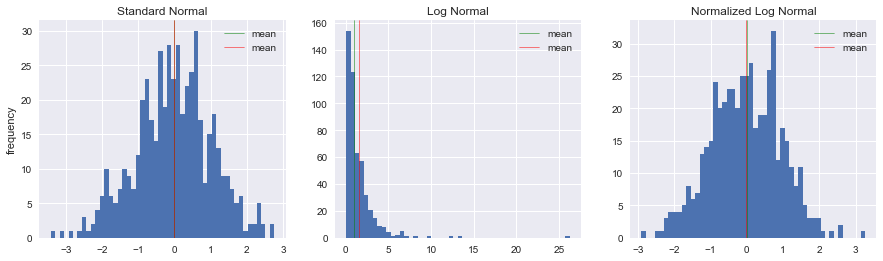

In [969]:
sample_size = 500
rn1 = npr.standard_normal(sample_size)
rn2 = npr.lognormal(size=sample_size)
rn3 = np.log(rn2)

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

ax1.hist(rn1, bins=50);
ax1.set_title('Standard Normal');
ax1.set_ylabel('frequency');
ax1.axvline(np.median(rn1), color='g', linewidth=0.5, label='mean');
ax1.axvline(rn1.mean(), color='r', linewidth=0.5, label='mean');
ax1.legend();

ax2.hist(rn2, bins=50);
ax2.set_title('Log Normal');
ax2.axvline(np.median(rn2), color='g', linewidth=0.5, label='mean');
ax2.axvline(rn2.mean(), color='r', linewidth=0.5, label='mean');
ax2.legend();

ax3.hist(rn3, bins=50);
ax3.set_title('Normalized Log Normal');
ax3.axvline(np.median(rn3), color='g', linewidth=0.5, label='mean');
ax3.axvline(rn3.mean(), color='r', linewidth=0.5, label='mean');
ax3.legend();

---

# Python for Algorithmic Trading

In [1056]:
%%time
import random
from math import exp, sqrt

S0 = 100
r  = 0.05
T  = 1.0
sigma = 0.2
values = []
for _ in range(1_000_000):
    ST = S0 * exp((r - 0.5 * sigma ** 2) * T + sigma * random.gauss(0, 1) * sqrt(T))
    values.append(ST)

CPU times: user 1.1 s, sys: 39.7 ms, total: 1.14 s
Wall time: 1.16 s


In [1057]:
%%time
import numpy as np

S0 = 100
r  = 0.05
T  = 1.0
sigma = 0.2

ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.random.standard_normal(1_000_000) * np.sqrt(T))

CPU times: user 42.7 ms, sys: 6.85 ms, total: 49.6 ms
Wall time: 49 ms


In [ ]:
%matplotlib inline
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

import configparser
c = configparser.ConfigParser()
